In [ ]:
import numpy as np
import itertools as t
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class NN():
    def __init__(self):
        self.layersOfWeights = []
        self.layersOfBiases = []
        self.layersOfActivFunc = []
        self.layersOfGradActivFunc = []
        self.len = 0

        self.lossFunc: list[function] = None
        """Содержит в себе три элемента: <br>
        [0] - функция потерь<br>
        [1] - градиент функции потерь<br>
        [2] - название функции потерь для графика<p>
        Ожидает получить сперва реальные значения, потом предсказанные"""

        self.zForEachLayer = []
        self.yForEachLayer = []

        self.errorDuringTraining = []

    def addLayer(self, n, m, q = 1):
        """Добавляет один скрытый слой.<br>
        n - число входных параметров<br>
        m - число нейронов в слое<br>
        q - значения """
        self.layersOfWeights.append( np.random.uniform(-q,q, (n,m)) )
        self.layersOfBiases.append( np.random.uniform(-q,q, (1,m)) )
        self.len+=1

    def addActivFunc(self, n = 0):
        """
        n - номер функции активации: <br>
        <b>0</b> - никакой функции активации. Выбор по умолчанию<br>
        <b>1</b> - сигмойда (1/1 + exp(-x))<br>
        <b>2</b> - гиперболический тангенс (tanh(x))<br>
        <b>3</b> - softmax (<i>Это не функция активации</i>, просто занести её сюда будет удобно на этапе предсказаний. Так-то она идёт вместе с кроссЭнтропией)
        """
        none = lambda x: x
        gradNone = lambda x: np.ones_like(x)

        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        gradSigmoid = lambda x: sigmoid(x) * (1 - sigmoid(x))

        tanh = lambda x: np.tanh(x)
        gradTanh = lambda x: 1 - (tanh(x)**2)

        def softmax(x):        
            shift = x - np.max(x, axis=1, keepdims=True)
            shift = np.clip(shift, -20, +20)
            ex = np.exp(shift)
            return ex / np.sum(ex, axis=1, keepdims=True)

        gradSoftmax = lambda x: np.ones_like(x)

        if n == 0:
            func = none
            gradFunc = gradNone
        elif n == 1:
            func = sigmoid
            gradFunc = gradSigmoid
        elif n == 2:
            func = tanh
            gradFunc = gradTanh
        elif n == 3:
            func = softmax
            gradFunc=gradSoftmax
        else:
            raise Exception("Неверное число для выбора функции активации")
        
        self.layersOfActivFunc.append(func)
        self.layersOfGradActivFunc.append(gradFunc)

    def loss(self, n=0):
        """Определяет функцию потерь для подсчёта ошибки и последующего обучения<br>
        0 - MSE<br>
        1 - CrossEntropy"""

        MSE = lambda y,x: ((x-y)**2).mean()
        gradMSE = lambda y,x: 2 * (x-y) 

        def crossEntropy(y,x):
            """y - реальные данные<br>
            х - предсказанные данные<p>
            Функция проверяет близость двух вероятностных распределений (выход из softmax'а). Чем меньше, тем лучше."""
            return  - (y * np.log(x)).sum(axis=1, keepdims=True).mean()

        def crossEntropyDerivative(y,x):
            """y - реальные данные<br>
            х - предсказанные данные<p>
            Функция ожидает на вход данные из softmax'а. """
            # return - (y / (np.log(10) * x)).sum(axis=1, keepdims=True)
            return x-y
        
        if n ==0:
            loss = MSE
            dLoss = gradMSE
            title = "MSE"
        elif n ==1:
            loss = crossEntropy
            dLoss = crossEntropyDerivative
            title = "CrossEntropy"
        else:
            raise Exception("Неверное число для выбора функции потерь")
        
        self.lossFunc = [loss, dLoss, title]

    def predict(self, data:np.ndarray):
        self.yForEachLayer.append(data)
        z = data @ self.layersOfWeights[0] + self.layersOfBiases[0]
        self.zForEachLayer.append(z)
        y = self.layersOfActivFunc[0](z)
        self.yForEachLayer.append(y)
        for i in range(1, self.len):
            z = z @ self.layersOfWeights[i] + self.layersOfBiases[i]
            self.zForEachLayer.append(z)   
            y = self.layersOfActivFunc[i](z)
            self.yForEachLayer.append(y)
        
        return y
    
    def _backprop(self, data:np.ndarray, y_true:np.ndarray, lr=0.001):
        self.predict(data)

        w = []
        b = []

        # error = e = ((self.yForEachLayer[-1] - y_true)**2).mean()
        error = e = self.lossFunc[0](y_true, self.yForEachLayer[-1])
        self.errorDuringTraining.append(float(e))

        #Первый слой
        # dedy = 2 * (self.yForEachLayer[-1] - y_true) #Это не одно число, хотя козалось бы
        dedy = self.lossFunc[1](y_true, self.yForEachLayer[-1])
        dydz = dedy * self.layersOfGradActivFunc[-1](self.zForEachLayer[-1])
        dzdw = self.yForEachLayer[-2].T @ dydz
        dzdb = np.sum(dydz, axis = 0, keepdims = True)
        w.append(dzdw)
        b.append(dzdb)
        dzdy = dydz @ self.layersOfWeights[-1].T

        #Все последующие
        for i in range(1, self.len):
            dydz = dzdy * self.layersOfGradActivFunc[-i-1](self.zForEachLayer[-i-1])
            dzdw = self.yForEachLayer[-i-2].T @ dydz
            dzdb = np.sum(dydz, axis = 0, keepdims = True)
            w.append(dzdw)
            b.append(dzdb)
            dzdy = dydz @ self.layersOfWeights[-i-1].T

        
        for i in range(self.len):
            self.layersOfWeights[-i-1] = self.layersOfWeights[-i-1] - w[i] * lr
            self.layersOfBiases[-i-1] = self.layersOfBiases[-i-1] - b[i] * lr
        

    
    def training(self, data:np.ndarray, y_true, epoch, batch_size=0, lr=0.001):
        self.errorDuringTraining.clear()
        if batch_size == 0:
            for i in range(epoch):
                self._backprop(data, y_true, lr)
        else:
            dataset = np.hstack((data, y_true))
            n_features = data.shape[1]
            for i in range(epoch):
                np.random.shuffle(dataset)
                for j in range(0, len(data), batch_size):
                    start_index = j
                    end_index = j + batch_size
                    batch_data = dataset[start_index : end_index]
                    self._backprop(batch_data[:, :n_features], batch_data[:, n_features:], lr)

        plt.figure()
        plt.plot(range(len(self.errorDuringTraining)), self.errorDuringTraining)
        plt.title("Процесс обучения")
        plt.xlabel("Номер итерации")
        plt.ylabel(f"Ошибка {self.lossFunc[2]}")

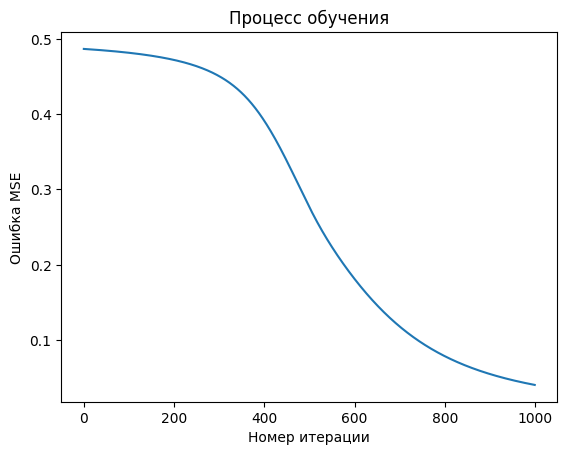

In [ ]:
import itertools
n = 6
x = np.array(list(itertools.product([0,1], repeat=n)))
y = x[:, 2].reshape(-1,1)

pipa = NN()
pipa.addLayer(n, 10)
pipa.addActivFunc(1)
pipa.addLayer(10,1)
pipa.addActivFunc(1)
pipa.loss(0)

pipa.training(x,y, 1000)

Accuracy:  1.0


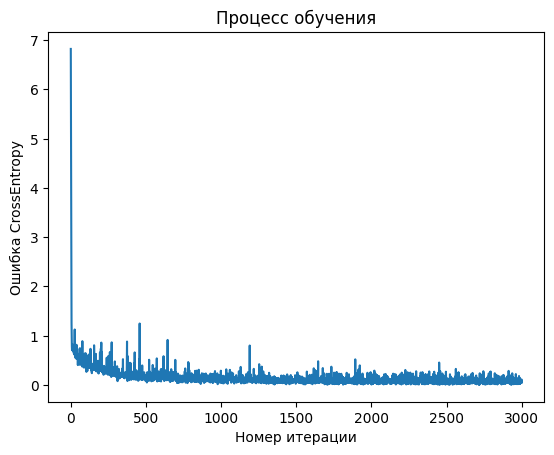

In [ ]:
from sklearn import datasets
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.metrics

data = datasets.load_iris()
x,y = data.data, data.target.reshape(-1,1)

pipa = NN()
pipa.addLayer(4,10)
pipa.addActivFunc(2)
pipa.addLayer(10,3)
pipa.addActivFunc(3)
pipa.loss(1)


a = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
z = a.fit_transform(y)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x,z, test_size=0.2)
pipa.training(X_train, y_train, epoch=1_000, batch_size=50)

print("Accuracy: ",sklearn.metrics.accuracy_score(pipa.predict(X_test).argmax(axis=1), y_test.argmax(axis=1)))

Accuracy:  0.9083333333333333


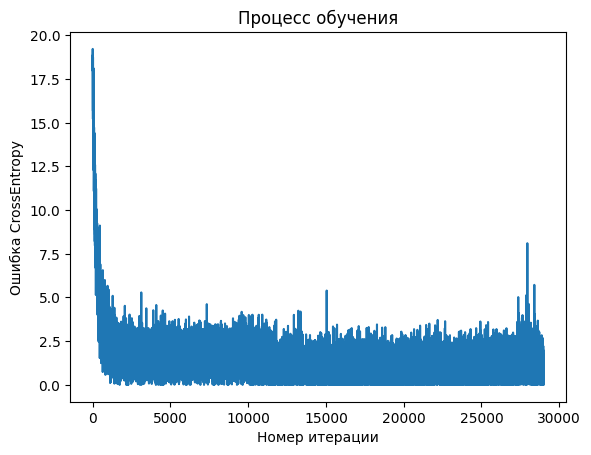

In [ ]:
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing

data = sklearn.datasets.load_digits()
x,y = data.data, data.target.reshape(-1,1)

a = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
z = a.fit_transform(y)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x,z, test_size=0.2)

pipa = NN()
pipa.addLayer(64, 20)
pipa.addActivFunc(2)
pipa.addLayer(20,10)
pipa.addActivFunc(3)
pipa.loss(1)


pipa.training(X_train, y_train, epoch=1_000, batch_size=50)
print("Accuracy: ",sklearn.metrics.accuracy_score(pipa.predict(X_test).argmax(axis=1), y_test.argmax(axis=1)))

In [ ]:
# Смотрим как изменились метки после обучения

import pandas as pd

# 5) Собираем DataFrame
df_results = pd.DataFrame({
    'TrueLabel':   true_labels,
    'PredBefore':  pred_labels_nt,
    'PredAfter':   pred_labels
})

df_results['Changed?'] = df_results['PredBefore'] != df_results['PredAfter']

df_results


In [ ]:
import itertools

# число прогонов для каждой комбинации (чем больше, тем точнее, но дольше)
n_repeats = 5

# 2) Сетка гиперпараметров
layer_configs = [
    [10],        # одна скрытая из 10 нейронов
    [20],        # одна скрытая из 20
    [10, 10],    # две по 10
    [3, 5, 3],
]
activ_choices = {
    1: "sigmoid",
    2: "tanh",
    3: "softmax"
}
weight_scales = [0.1, 1.0, 0.01]
lrs = [0.001, 0.01, 0.1]

results = []

# 3) Grid search с повторениями
for hidden, act_code, scale, lr in itertools.product(
        layer_configs, activ_choices, weight_scales, lrs):

    accs = []
    for run in range(n_repeats):
        # фиксируем семя, чтобы разные запуски отличались, но было воспроизводимо
        seed = 42 + run
        np.random.seed(seed)

        net = NN()
        prev_dim = X_train.shape[1]
        # создаём скрытые слои
        for size in hidden:
            net.addLayer(prev_dim, size)
            net.addActivFunc(act_code)
            prev_dim = size
        # выходной softmax-слой
        net.addLayer(prev_dim, Y_train.shape[1])
        net.addActivFunc(3)
        # масштабируем стартовые веса
        for i in range(len(net.layersOfWeights)):
            net.layersOfWeights[i] *= scale

        # обучаем
        net.training(
            X_train, Y_train,
            steps=200,
            lr=lr,
            chart=False
        )

        # валидация
        pred = net.predict(X_test)
        pred_labels = np.argmax(pred, axis=1)
        true_labels = np.argmax(Y_test, axis=1)
        accs.append((pred_labels == true_labels).mean())

    # после n_repeats считаем метрики стабильности
    mean_acc = np.mean(accs)
    std_acc  = np.std(accs)

    results.append({
        "hidden_layers": hidden,
        "activation":   activ_choices[act_code],
        "weight_scale": scale,
        "learning_rate": lr,
        "mean_acc":     mean_acc,
        "std_acc":      std_acc,
        "all_runs":     accs
    })

# 4) Сводная таблица: сортируем по убыванию mean_acc, затем по возрастанию std_acc
df = pd.DataFrame(results)
df = df.sort_values(["mean_acc", "std_acc"], ascending=[False, True]).reset_index(drop=True)

# посмотрим топ-10 самых стабильных и высоко среднеработающих конфигураций
df.head(10)
